## **<span style="color:lime">First section</span>: *basic operations***
| *Cells* | *Content* |
|---|---|
| 1.1 *Setup* | Imports, shared helpers, and reproducibility |
| 1.2 *Tree + Encoder/Decoder* | Build a configuration and inspect leaf intervals |
| 1.3 *Path & Prefix* | Encode full paths and prefixes; decode prefixes |
| 1.4 *Delta & Salt* | Expanded range and salted tokens |
| 1.5 *Deterministic vs Randomized* | Side‑by‑side behavior and path length |
| 1.6 *Three signatures* | Leaf hash vs prefix multihash vs full path multihash |
| 1.7 *Randomized path lengths* | Distribution of randomized path lengths |

#### **<span style="color:purple">Notes</span>**
This notebook shows the updated HashComb API (encoders/decoders/core).

# HashComb — Basics

In [22]:
from pathlib import Path
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Make local package importable
root = Path.cwd()
nb_dir = root / "notebooks"

# Walk up to find repository root (pyproject.toml)
repo_root = root
for _ in range(5):
    if (repo_root / "pyproject.toml").exists():
        break
    if repo_root.parent == repo_root:
        break
    repo_root = repo_root.parent

src_dir = repo_root / "src"
if src_dir.exists():
    sys.path.append(str(src_dir))

from hashcomb import Encoder, RandomizedEncoder, Decoder, Tree, RoundContext

# Import shared plotting helpers from notebooks/
if (nb_dir / "utils_plot.py").exists():
    sys.path.append(str(nb_dir))
elif (repo_root / "notebooks" / "utils_plot.py").exists():
    sys.path.append(str(repo_root / "notebooks"))
elif (repo_root / "utils_plot.py").exists():
    sys.path.append(str(repo_root))

from utils_plot import (
    collect_leaves,
    plot_leaves_strip,
    path_for_value,
    plot_tree_levels,
    visualize_config_pkl,
)

### 1.2 *Tree + Encoder/Decoder*

Leaves: 31


,hash,min,center,max,width
0,120720020,0.0000,7.50000,15.0000,15.0000
1,111267611,0.0000,3.75000,7.5000,7.5000
2,191490743,0.0000,1.87500,3.7500,3.7500
3,83914535,0.0000,0.93750,1.8750,1.8750
4,207770464,0.0000,0.46875,0.9375,0.9375
5,114439058,0.9375,1.40625,1.8750,0.9375
6,205006580,1.8750,2.81250,3.7500,1.8750
7,73768080,1.8750,2.34375,2.8125,0.9375
8,156069733,2.8125,3.28125,3.7500,0.9375
9,176485186,3.7500,5.62500,7.5000,3.7500


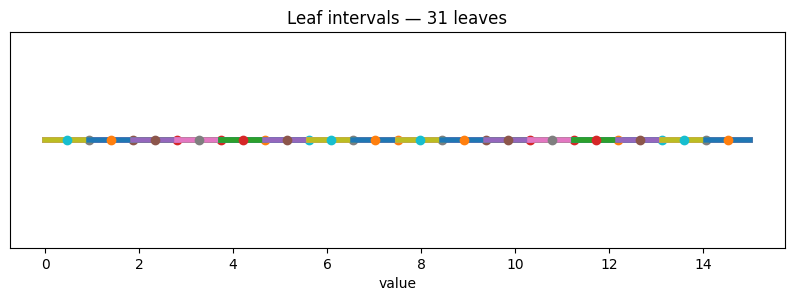

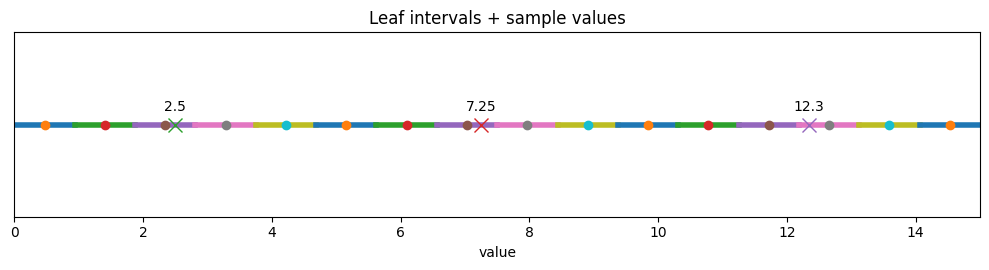

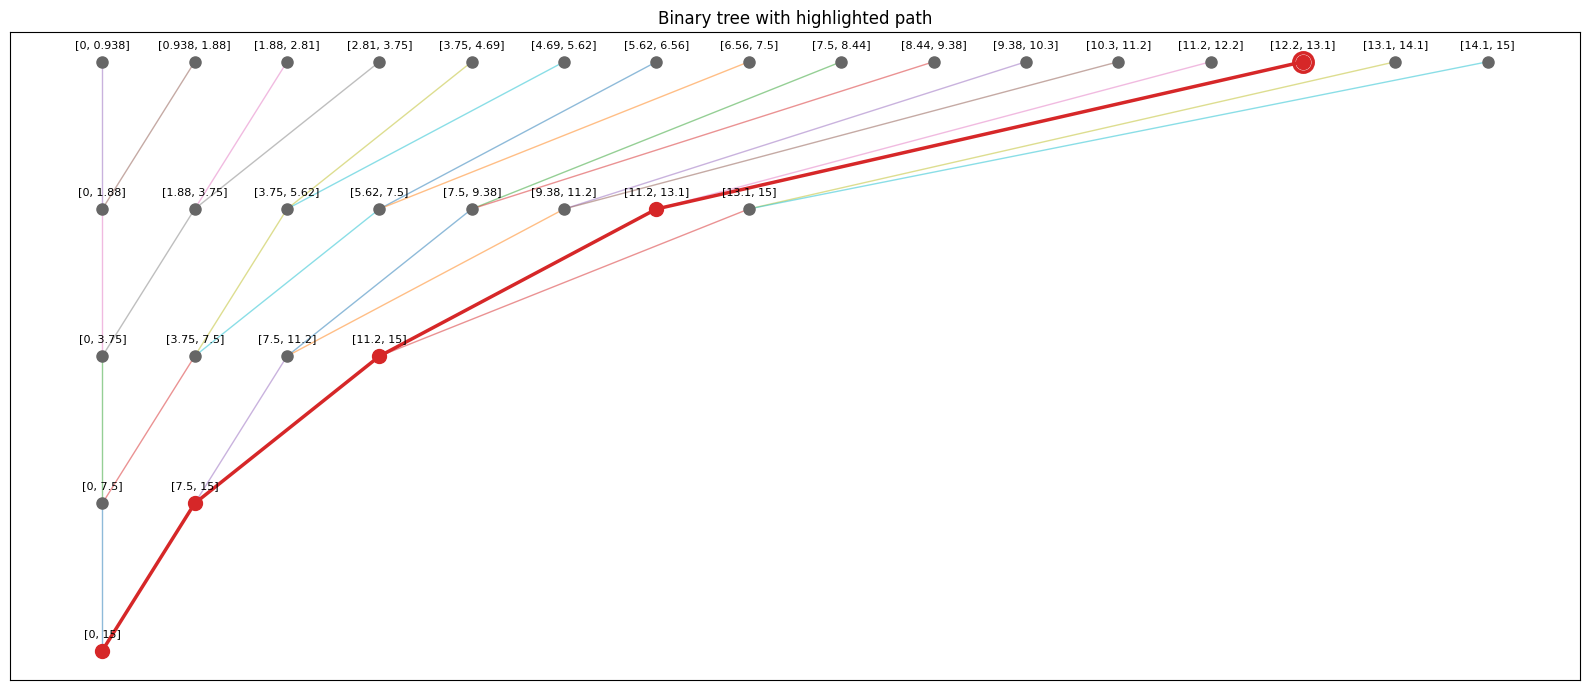

In [23]:
channels = 4
min_val = 0.0
max_val = 15.0
config_path = "artifacts/configuration.pkl"

enc = Encoder(channels, max_val, min_val, configPath=config_path, includeInternal=True)
dec = Decoder(configPath=config_path)

print("Leaves:", len(enc.hashMap))
df = visualize_config_pkl(config_path, show_table=True)

t = Tree(channels, max_val, min_val)
leaves = collect_leaves(t.root)
plot_leaves_strip(leaves, inputs=[2.5, 7.25, 12.34], title="Leaf intervals + sample values")
highlight = path_for_value(t.root, 12.34)
plot_tree_levels(t.root, highlight_path=highlight, title="Binary tree with highlighted path")

### 1.3 *Path & Prefix*

In [24]:
value = 7.25
leaf = enc.encode(value)
path = enc.encodePath(value)
prefix = enc.encodePrefix(value, length=2)

print("Leaf token:", leaf)
print("Path:", path)
print("Prefix (len=2):", prefix)

print("Decode leaf:", dec.decode(leaf))
print("Decode prefix (uses last token):", dec.decodePath(prefix))

Leaf token: 238417091
Path: ['111267611', '176485186', '144767448', '238417091']
Prefix (len=2): ['111267611', '176485186']
Decode leaf: 7.03125
Decode prefix (uses last token): 5.625


### 1.4 *Delta & Salt*

In [25]:
enc_delta = Encoder(channels, max_val, min_val, delta=0.5, configPath="artifacts/config_delta.pkl")
enc_salt = Encoder(channels, max_val, min_val, salt="roundA", configPath="artifacts/config_salt.pkl")

v = 12.34
print("delta range:", enc_delta.min, enc_delta.max)
print("salted token:", enc_salt.encode(v))

delta range: -0.5 15.5
salted token: 198273590


### 1.5 *Deterministic vs Randomized*
We compare the same inputs under deterministic and randomized encoders.

In [26]:
ctx = RoundContext(salt="roundX", seed=123)
enc_det = Encoder(channels, max_val, min_val, salt="roundX", configPath="artifacts/det.pkl")
enc_rand = RandomizedEncoder(channels, max_val, min_val, selectionProbability=0.5, roundContext=ctx, configPath="artifacts/rand.pkl")

xs = np.linspace(min_val, max_val, 30)
det_tokens = [enc_det.encode(x) for x in xs]
rand_tokens = [enc_rand.encode(x) for x in xs]

print("Deterministic unique tokens:", len(set(det_tokens)))
print("Randomized unique tokens:", len(set(rand_tokens)))

# Path length distribution for randomized encoder
lengths = [len(enc_rand.encodePath(x)) for x in xs]
print("Randomized path lengths:", sorted(set(lengths)))

Deterministic unique tokens: 16
Randomized unique tokens: 22
Randomized path lengths: [2, 3, 4]


### 1.6 *Three signatures*
We show three ways to represent a value:
1) leaf token, 2) prefix multihash of length $k$, 3) full path multihash (root→leaf).

In [27]:
v = 7.25
k = 2

leaf_token = enc.encode(v)
prefix_tokens = enc.encodePrefix(v, length=k)
full_path_tokens = enc.encodePath(v)

print("Value:", v)
print("Leaf token:", leaf_token)
print(f"Prefix tokens (k={k}):", prefix_tokens)
print("Full path tokens:", full_path_tokens)
print("Lengths:", {
    "leaf": 1,
    "prefix": len(prefix_tokens),
    "full": len(full_path_tokens),
})

Value: 7.25
Leaf token: 238417091
Prefix tokens (k=2): ['111267611', '176485186']
Full path tokens: ['111267611', '176485186', '144767448', '238417091']
Lengths: {'leaf': 1, 'prefix': 2, 'full': 4}


### 1.7 *Randomized path lengths*
Distribution of path lengths produced by `RandomizedEncoder`.

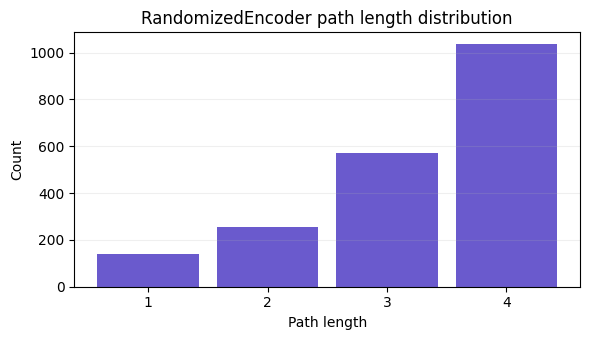

1     140
2     255
3     570
4    1035
Name: count, dtype: int64

In [28]:
rng = np.random.default_rng(123)
values_rand = rng.uniform(min_val, max_val, size=2000)

lengths_rand = [len(enc_rand.encodePath(v)) for v in values_rand]

plt.figure(figsize=(6, 3.5))
plt.hist(lengths_rand, bins=np.arange(1, channels + 2) - 0.5, rwidth=0.85, color="slateblue")
plt.xticks(range(1, channels + 1))
plt.xlabel("Path length")
plt.ylabel("Count")
plt.title("RandomizedEncoder path length distribution")
plt.grid(axis="y", alpha=0.2)
plt.tight_layout()
plt.show()

counts = pd.Series(lengths_rand).value_counts().sort_index()
counts